In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:
import json

with open('/home/eduardo/Documents/Persona3/AutoTelos/fusion_navigator/personae.json', 'r') as fp:
    personae = json.load(fp)

# open json file and read contenta as a list of dictionaries
with open('/home/eduardo/Documents/Persona3/AutoTelos/fusion_navigator/combos2.json', 'r') as fp:
    arcana2Combos = json.load(fp)

with open('/home/eduardo/Documents/Persona3/AutoTelos/fusion_navigator/combos3.json', 'r') as fp:
    arcana3Combos = json.load(fp)

with open('/home/eduardo/Documents/Persona3/AutoTelos/fusion_navigator/specialCombos.json', 'r') as fp:
    specialCombos = json.load(fp)


# In[3]:


class PersonaCompendiumExtracted:
    def __init__(self, name, level, skills):
        self.name = name
        self.level = level
        self.skills = skills

import json

# Load the JSON file
with open('/home/eduardo/Documents/Persona3/AutoTelos/fusion_navigator/persona_compendium_save_file.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
# Create Persona objects
personas_compendium_extracted = [PersonaCompendiumExtracted(item['name'], item['level'], item['skills']) for item in data]

for persona in personae:
    persona['base_level+5'] = persona['level'] + 5 # max social links lead to a +5 bonus
    persona['base_level'] = persona['level']

# overwrite 'personae' with the new list
for persona_compendium_extracted in personas_compendium_extracted:
    for persona in personae:
        if persona_compendium_extracted.name.lower() == persona['name'].lower():
            persona['level'] = persona_compendium_extracted.level
            persona['skills'] = persona_compendium_extracted.skills
            break

# In[5]:


import math

def generate_arcana_rank(personae):
    arcana_rank = {}
    rank = 0
    last_arcana = None
    for persona in personae:
        if persona['arcana'] == last_arcana:
            continue
        last_arcana = persona['arcana']
        arcana_rank[persona['arcana']] = rank
        rank += 1
    return arcana_rank

# Assuming 'personae' is a list of dictionaries with an 'arcana' key.
# You need to define or import this list from your data.
arcana_rank = generate_arcana_rank(personae)

def generate_personae_by_name(personae):
    personae_by_name = {}
    for persona in personae:
        personae_by_name[persona['name']] = persona
    return personae_by_name

personae_by_name = generate_personae_by_name(personae)

def generate_personae_by_arcana(personae):
    personae_by_arcana = {}
    for persona in personae:
        arcana = persona['arcana']
        if arcana not in personae_by_arcana:
            personae_by_arcana[arcana] = []
        personae_by_arcana[arcana].append(persona)
    return personae_by_arcana

# Assuming 'personae' is a list of dictionaries with at least an 'arcana' key.
# You need to define or import this list from your data.
personae_by_arcana = generate_personae_by_arcana(personae)




class CalcCtrl:
    def __init__(self, persona_name, is_intermediate_fusion=False):
        self.ceil = math.ceil
        
        self.level_key = 'base_level'

        if is_intermediate_fusion:
            self.current_level_key = 'base_level+5'
        else:
            self.current_level_key = 'level'

        self.persona = personae_by_name.get(persona_name)

        self.all_recipes = []  # Consider renaming this to just 'recipes' for consistency with other methods
        if self.persona:
            self.get_recipes()
            self.all_recipes.sort(key=lambda x: x['cost'])
            self.max_cost = max(recipe['cost'] for recipe in self.all_recipes) if self.all_recipes else 0

    @staticmethod
    def get_rank(persona):
        return arcana_rank[persona['arcana']]

    def add_recipe(self, recipe):
        recipe['cost'] = sum((27 * source[self.level_key]**2 + 126 * source[self.level_key] + 2147) for source in recipe['sources'])
        recipe['sources'].sort(key=lambda x: (-x[self.level_key], self.get_rank(x)))
        self.all_recipes.append(recipe)

    def fuse2(self, arcana, persona1, persona2):
        level = 1 + (persona1[self.level_key] + persona2[self.level_key]) // 2
        personae = personae_by_arcana[arcana]

        for i, persona in enumerate(personae):
            if persona[self.level_key] >= level:
                if persona.get('special'):
                    continue
                break

        if persona1['arcana'] == persona2['arcana']:
            i -= 1
        if i < len(personae) and (personae[i] == persona1 or personae[i] == persona2):
            i -= 1

        return personae[max(i, 0)]  # Ensure i doesn't go below 0

    def fuse3(self, arcana, persona1, persona2, persona3):
        level = 5 + (persona1[self.level_key] + persona2[self.level_key] + persona3[self.level_key]) // 3
        personae = personae_by_arcana[arcana]

        found = False
        for i, persona in enumerate(personae):
            if persona[self.level_key] >= level:
                if persona.get('special'):
                    continue
                found = True
                break

        if not found:
            return None

        # In same arcana fusion, skip over the ingredients.
        if persona1['arcana'] == arcana and persona2['arcana'] == arcana and persona3['arcana'] == arcana:
            while (i < len(personae) and (persona1['name'] == personae[i]['name'] or
                                          persona2['name'] == personae[i]['name'] or
                                          persona3['name'] == personae[i]['name'])):
                i += 1
                if i >= len(personae):
                    return None

        return personae[i] if i < len(personae) else None
    
    def persona3_is_valid(self, persona1, persona2, persona3):
        if persona3 == persona1 or persona3 == persona2:
            return False

        if persona3[self.current_level_key] < persona1[self.current_level_key] or persona3[self.current_level_key] < persona2[self.current_level_key]:
            return False

        if persona3[self.current_level_key] == persona1[self.current_level_key]:
            return arcana_rank[persona3['arcana']] < arcana_rank[persona1['arcana']]

        if persona3[self.current_level_key] == persona2[self.current_level_key]:
            return arcana_rank[persona3['arcana']] < arcana_rank[persona2['arcana']]

        return True

    def find_3way_recipes(self, arcana1, arcana2):
        step1_recipes = self.get_arcana_recipes(arcana1)
        for step1_recipe in step1_recipes:
            persona1 = step1_recipe['sources'][0]
            persona2 = step1_recipe['sources'][1]
            personae = personae_by_arcana[arcana2]

            for persona3 in personae:
                if self.persona3_is_valid(persona1, persona2, persona3):
                    result = self.fuse3(self.persona['arcana'], persona1, persona2, persona3)
                    if not result or result['name'] != self.persona['name']:
                        continue

                    # filter if persona1,persona2 or persona3 name are equal to result
                    if persona1['name'] == result['name'] or persona2['name'] == result['name'] or persona3['name'] == result['name']:
                        continue

                    self.add_recipe({'sources': [persona1, persona2, persona3]})

    def get_recipes(self):
        if self.persona.get('special'):
            for combo in specialCombos:
                if self.persona['name'] == combo['result']:
                    recipe = {'sources': [personae_by_name[source] for source in combo['sources']]}
                    self.add_recipe(recipe)
                    return
        
         # Define filter_2way inside get_recipes
        def filter_2way(persona1, persona2, result):
            # Note: 'self' is accessible here because this is an inner function
            if persona1['name'] ==  self.persona['name']:
                return True
            if persona2['name'] ==  self.persona['name']:
                return True
            if result['name'] ==  self.persona['name']:
                return False
            return True
        


        recipes = self.get_arcana_recipes(self.persona['arcana'], filter_2way)
        for recipe in recipes:
            self.add_recipe(recipe)

        # Consider triangle fusion
        combos = [combo for combo in arcana3Combos if combo['result'] == self.persona['arcana']]
        for combo in combos:
            self.find_3way_recipes(combo['source'][0], combo['source'][1])
            if combo['source'][1] != combo['source'][0]:
                self.find_3way_recipes(combo['source'][1], combo['source'][0])
    
    def get_arcana_recipes(self, arcana_name, filter_callback=None):
        recipes = []
        combos = [x for x in arcana2Combos if x['result'] == arcana_name]

        for combo in combos:
            personae1 = personae_by_arcana[combo['source'][0]]
            personae2 = personae_by_arcana[combo['source'][1]]

            for i, persona1 in enumerate(personae1):
                for j, persona2 in enumerate(personae2):
                    if persona1['arcana'] == persona2['arcana'] and j <= i:
                        continue
                    result = self.fuse2(combo['result'], persona1, persona2)
                    if not result:
                        continue
                    if filter_callback and filter_callback(persona1, persona2, result):
                        continue

                    recipes.append({'sources': [persona1, persona2]})

        return recipes

#calc_ctrl = CalcCtrl('chi you', is_intermediate_fusion=False)
#calc_ctrl = CalcCtrl('orpheus telos', is_intermediate_fusion=True)
#print(calc_ctrl.all_recipes)


def print_sources(recipes, file):
    for recipe in recipes:
        print("Recipe:", file=file)
        for source in recipe['sources']:
            name = source.get('name', 'Unknown')
            level = source.get('level', 'Unknown')
            arcana = source.get('arcana', 'Unknown')
            special = ' (special)' if source.get('special') else ''
            print(f"  - {name}, Level: {level}, Arcana: {arcana}{special}", file=file)
        cost = recipe.get('cost', 'Unknown')
        print(f"Total Cost: {cost}\n", file=file)


# In[17]:


# open dataframe located in "/home/eduardo/Documents/Persona3/AutoTelos/skills_list/skills.csv"
import pandas as pd
df = pd.read_csv("/home/eduardo/Documents/Persona3/AutoTelos/skills_list/skills.csv")


#print(df)

skill_type_dict = df.set_index('skill')['type'].to_dict()

skill_rank_dict = df.set_index('skill')['rank'].to_dict()


# given a skill name return the skill type
def get_skill_type(skill_name):
    return skill_type_dict[skill_name]

def get_skill_rank(skill_name):
    return skill_rank_dict[skill_name]

#print(get_skill_type('Agidyne'))

persona_name = 'chi you'

# load '/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/inheritance.csv' into a dataframe
inheritance_df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/inheritance.csv')
# load '/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/personas_inheritance.csv' into a dataframe
persona_inheritance_df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/personas_inheritance.csv')

# get the type of the persona 'chi you' in the persona_inheritance_df
persona_inherit_type = persona_inheritance_df.loc[persona_inheritance_df['Persona'] == persona_name, 'Type'].iloc[0]


# Convert the DataFrame to a dictionary where each key is an inheritance type
# and its value is another dictionary of skill types and their probabilities.
inheritance_dict = inheritance_df.set_index('Inheritance Type').T.to_dict('dict')



# given a skill type return the skill inheritance probability for a given persona type
def get_inheritance_probability(skill_type, persona_inheritance_type):
    # Access the nested dictionary directly for the value
    # Check if the persona_inheritance_type exists to avoid KeyErrors
    if persona_inheritance_type in inheritance_dict:
        # Return the probability value for the given skill_type and persona_inheritance_type
        return inheritance_dict[persona_inheritance_type].get(skill_type, 0)  # Returns 0 if skill_type is not found


#print(get_inheritance_probability('Almighty', persona_inherit_type))


def get_ammount_of_inherited_skills(skills):
    if len(skills) < 6:
        return 1
    elif len(skills) < 9:
        return 2
    elif len(skills) < 12:
        return 3
    elif len(skills) < 24:
        return 4
    elif len(skills) < 32:
        return 5
    elif len(skills) < 40:
        return 6
    elif len(skills) < 48:
        return 7
    else:
        return 8
    
def create_desired_skills_probability_dict(desired_skills):
    desired_skills_probability_dict = {}
    for s in desired_skills:
        skill_type = get_skill_type(s)
        desired_skills_probability_dict[s] = get_inheritance_probability(skill_type, persona_inherit_type)
    return desired_skills_probability_dict
    
def get_best_recipe(desired_skills, recipes_list):

    best_ratio = 0
    best_ratio_max = 0
    best_recipe = recipes_list[0]
    best_set = None

    best_ratio_max = 0
    best_recipe_max = best_recipe
    best_set_max = best_set
    best_skills_max = best_set

    biggest_ammount_of_inherited_skills = 0

    for i in range(len(recipes_list)):
        current_skills = []
        dont_have = False

        lucifer = False
        norn = False
        baal_zebul = False

        for j in range(len(recipes_list[i]['sources'])):
            # if 'skills' key does not exist continue
            if 'skills' not in recipes_list[i]['sources'][j]:
                dont_have = True
                continue
            for s in recipes_list[i]['sources'][j]['skills']:
                current_skills.append(s)
            if recipes_list[i]['sources'][j]['name'] == 'lucifer':
                lucifer = True
            if recipes_list[i]['sources'][j]['name'] == 'norn':
                norn = True
            if recipes_list[i]['sources'][j]['name'] == 'baal zebul':
                baal_zebul = True
            if lucifer and baal_zebul and norn:
                #print('hello')
                None
            
        
        if dont_have:
            continue

        ammount_of_inherited_skills = get_ammount_of_inherited_skills(current_skills)

        

        if ammount_of_inherited_skills > biggest_ammount_of_inherited_skills:
            best_ratio_max = 0
            best_recipe_max = None
            best_set_max = None
            biggest_ammount_of_inherited_skills = ammount_of_inherited_skills
            

        set_current_skills = list(set(current_skills))
        
        #count how many skills of the desired skills are in the current skills
        desired_count = 0
        
        # while 'ammount_of_inherited_skills' is not reached count as many 'desired_skills' as possible. If space still remais count 'noise_skills'
        for s in set_current_skills:
            skill_type = get_skill_type(s)
            if s in desired_skills:
                ratio_skill = get_inheritance_probability(skill_type, persona_inherit_type)
                if ratio_skill > 0:
                    desired_count += 1
        
        
        current_desired_skills = []

        #count how many skills of the desired skills are in the current skills
        desired_count_ratio = 0
        noise_count_ratio = 0
        for s in set_current_skills:
            # get the skill type from the dataframe
            skill_type = get_skill_type(s)

            ratio_skill = get_inheritance_probability(skill_type, persona_inherit_type)
            if s in desired_skills:
                current_desired_skills.append(s)
                desired_count_ratio += ratio_skill
            else:
                noise_count_ratio += ratio_skill

        # should it be 1 or something between? should i switch nominator and denominator?   
        ratio = desired_count_ratio / max(noise_count_ratio,1)

        # the bigger the ratio the better
        if ratio > best_ratio:
            best_ratio = ratio
            best_recipe = recipes_list[i]
            best_set = set_current_skills
            best_desired_skills_prob_dict = create_desired_skills_probability_dict(current_desired_skills)
        
        if desired_count >= biggest_ammount_of_inherited_skills and ammount_of_inherited_skills == biggest_ammount_of_inherited_skills and ratio > best_ratio_max:
            best_ratio_max = ratio
            best_recipe_max = recipes_list[i]
            best_set_max = set_current_skills
            best_skills_max = current_skills
            best_desired_skills_prob_dict_max = create_desired_skills_probability_dict(current_desired_skills)

        if 2185 == i:
            running_ratio = ratio
            running_recipe = recipes_list[i]
            running_set = set_current_skills

    return best_ratio, best_recipe, best_set, best_desired_skills_prob_dict, biggest_ammount_of_inherited_skills, best_ratio_max, best_recipe_max, best_set_max, best_skills_max, best_desired_skills_prob_dict_max, running_ratio, running_recipe, running_set


#chi_you_base = CalcCtrl(persona_name, is_intermediate_fusion=False).all_recipes



mandatory_skills = [
'High Counter',
'Unshaken Will',
'Panta Rhei',
]

optional_skills = [
'Wind Boost',
'Wind Amp',
'Spell Master',
'Mind Charge',
'Salvation',
]

desired_skills = mandatory_skills + optional_skills

#best_ratio, best_recipe, best_set, best_desired_skills_prob_dict, biggest_ammount_of_inherited_skills, best_ratio_max, best_recipe_max, best_set_max, best_skills_max, best_desired_skills_prob_dict_max, running_ratio, running_recipe, running_set = get_best_recipe(desired_skills=desired_skills, recipes_list=chi_you_base)


In [2]:
import pandas as pd

# Read the CSV file
persona_inheritance_df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/personas_inheritance.csv')

# Convert the dataframe to a dictionary
persona_inheritance_dict = persona_inheritance_df.set_index('Persona')['Type'].to_dict()

def get_persona_inheritance_type(persona_name):
    # Use the dictionary for fast lookups
    return persona_inheritance_dict.get(persona_name)

# Example usage
#persona_inheritance_type = get_persona_inheritance_type("chi you")


In [3]:
# open json file into a dictionary

def load_empty_total_dict():
        
    with open('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/combinations.json', 'r') as fp:
        total_combinations_dict = json.load(fp)

    total_combinations_dict_new = {}

    # for each key in the dictionary convert the tuple string in a tuple
    for key in total_combinations_dict:
        eval_key = eval(key)
        total_combinations_dict_new[eval_key] = 0


    total_dict = total_combinations_dict_new

    return total_dict


In [4]:
import ast

import pandas as pd
# Load the CSV file into a DataFrame
df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/skills_list/inheritable_skills_with_levels.csv')

#print all lines of the dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    None
    #print(df)

class UnlockableSkill:
    def __init__(self, name, level=None):
        self.name = name
        self.level = level

    def __repr__(self):
        if self.level:
            return f"('{self.name}', lv{self.level})"
        else:
            return f"('{self.name}')"


def extract_skills(data):
    skill_dict = {}
    for persona, skills_str in zip(data['persona'], data['skill']):
        # Safely evaluate the string as a list
        skills = ast.literal_eval(skills_str)
        skill_list = []
        for skill in skills:
            # Check if there's a level specified in the skill string
            if '(' in skill and ')' in skill:
                name, level_str = skill.rsplit('(', 1)
                level = int(level_str[:-1])  # Remove the closing parenthesis and convert to int
            else:
                name, level = skill, None

            skill_list.append(UnlockableSkill(name.strip(), level))
        
        skill_dict[persona] = skill_list

    return skill_dict

skill_dict = extract_skills(df)
for persona, skills in skill_dict.items():
    None
    #print(f"{persona}: {skills}")


# verify if for any persona in the dictionary, if it's skills have level numbers that repeat
for persona, skills in skill_dict.items():
    levels = [skill.level for skill in skills]
    # remove 'None' values from the list
    levels = [level for level in levels if level is not None]
    if len(levels) != len(set(levels)):
        print(f"Persona {persona} has repeated levels: {levels}")

def ammount_of_base_skills(persona_name):
    persona_skills = skill_dict[persona_name]
    base_skills = [skill for skill in persona_skills if skill.level is None]
    return len(base_skills)

print(ammount_of_base_skills('chi you'))

2


In [5]:
!pip install bitarray

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [6]:
from itertools import product
from tqdm import tqdm
from bitarray import bitarray


class Persona:
    def __init__(self, data):
        self.name = data.get('name', 'Unknown')
        self.level = data.get('level', 0)
        self.arcana = data.get('arcana', 'Unknown')
        self.special = data.get('special', False)
        self.base_level = data.get('base_level', 0)
        self.base_level_plus_5 = data.get('base_level+5', self.base_level + 5)
        self.skills = data.get('skills', [])
        self.all_recipes = CalcCtrl(self.name, is_intermediate_fusion=False).all_recipes
        self.ammount_of_base_skills = ammount_of_base_skills(self.name)

    def __str__(self):
        return (f"Name: {self.name}\n"
                f"Level: {self.level}\n"
                f"Arcana: {self.arcana}\n"
                f"Special: {self.special}\n"
                f"Base Level: {self.base_level}\n"
                f"Base Level + 5: {self.base_level_plus_5}\n"
                f"Skills: {', '.join(self.skills)}\n"
                f"Ammount of Base Skills: {self.ammount_of_base_skills}\n")

all_personas = {}

# beging search

def are_all_values_true(dictionary):
    return all(dictionary.values())

minimal_ammout_of_recipes = 0
''' 
class Recipe():
    def __init__(self, personas, skills_set, resulting_persona_name=None, coverage_dict=None):
        self.personas = personas
        self.skills_set = skills_set
        self.resulting_persona_name = resulting_persona_name
        self.ammount_of_base_skills = ammount_of_base_skills(resulting_persona_name)
        self.ammount_of_inherited_skills = get_ammount_of_inherited_skills(self.skills_set)


        # Sort and enumerate keys
        sorted_keys = sorted(coverage_dict.keys())
        key_index_map = {key: index for index, key in enumerate(sorted_keys)}

        # Create a bitarray for the values
        bit_values = bitarray(len(sorted_keys))
        for key, value in sorted_keys:
            bit_values[key_index_map[key]] = value
        
        self.coverage_bits = bit_values
    
    @property
    def coverage_dict(self):

         # Sort and enumerate keys
        sorted_keys = sorted(total_dict.keys())
        key_index_map = {key: index for index, key in enumerate(sorted_keys)}

        dictionary = {}

        for key, _ in enumerate(sorted_keys):
            index = key_index_map[key]
            dictionary[key] = self.coverage_bits[index]


        return self._coverage_dict   
'''

class Recipe():
    def __init__(self, personas, skills_set, resulting_persona_name, coverage_dict=None):
        self.personas = personas
        self.skills_set = skills_set
        self.resulting_persona_name = resulting_persona_name
        self.amount_of_base_skills = ammount_of_base_skills(resulting_persona_name)  # Assuming this is defined elsewhere
        self.amount_of_inherited_skills = get_ammount_of_inherited_skills(self.skills_set)  # Assuming this is defined elsewhere

        # Sort and enumerate keys of the initial coverage_dict
        sorted_keys = sorted(coverage_dict.keys())
        self.key_index_map = {key: index for index, key in enumerate(sorted_keys)}

        # Create a bitarray for the values
        self.coverage_bits = bitarray(len(sorted_keys))
        for key, value in coverage_dict.items():
            self.coverage_bits[self.key_index_map[key]] = value

        # empty the variable to free memory
        coverage_dict = None

    @property
    def coverage_dict(self):
        # Reconstruct the dictionary from the bitarray
        return {key: self.coverage_bits[index] for key, index in self.key_index_map.items()}



        


    def __str__(self):
        # count ammount of true values in the dictionary
        count = sum(self.coverage_dict.values())

        persona_names = [persona.name for persona in self.personas]

        return (f"Personas: {persona_names}\n"
                f"Skills: {self.skills_set}\n"
                f"Resulting Persona: {self.resulting_persona_name}\n"
                f"Coverage: {self.coverage_dict}\n"
                f"Coverage Ammount: {count}\n"
                f"Base Skills Ammount: {self.ammount_of_base_skills}\n"
                f"Inherited Skills Ammount: {self.ammount_of_inherited_skills}\n"
                "------------------------\n")
    
    def __repr__(self):

        count = sum(self.coverage_dict.values())

        persona_names = [persona.name for persona in self.personas]

        return (f"Personas: {persona_names}\n"
                f"Skills: {self.skills_set}\n"
                f"Resulting Persona: {self.resulting_persona_name}\n"
                f"Coverage: {self.coverage_dict}\n"
                f"Coverage Ammount: {count}\n"
                f"Base Skills Ammount: {self.ammount_of_base_skills}\n"
                f"Inherited Skills Ammount: {self.ammount_of_inherited_skills}\n"
                "------------------------\n")


total_dict = load_empty_total_dict()

# giant list of recipes
for persona in tqdm(personae):
    persona_name = persona['name']

    persona_inherit_type = get_persona_inheritance_type(persona_name)

    if persona_name not in all_personas:
        # Convert JSON string to dictionary
        # Create Persona object
        current_p = Persona(persona)
        all_personas[persona_name] = current_p
    else:
        current_p = all_personas[persona_name]
    
    all_recipes = current_p.all_recipes

    for recipe in all_recipes:
        # make all values in the dictionary be the last iteration
        personas = []
        recipe_skills = []

        coverage_dict = total_dict.copy()
        for parent in recipe['sources']:
            name = parent.get('name', 'Unknown')
            if name not in all_personas:
                # Convert JSON string to dictionary
                # Create Persona object
                current_p = Persona(parent)
                all_personas[name] = current_p
            else:
                current_p = all_personas[name]
            personas.append(current_p)
            
            for s in current_p.skills:
                recipe_skills.append(s)

            for s in current_p.skills:
                skill_type = get_skill_type(s)
                skill_rank = get_skill_rank(s)
                triple_rank_skilltype_inherittype = (persona_inherit_type, skill_rank, skill_type)
                coverage_dict[triple_rank_skilltype_inherittype] = True
                
        recipe_skills_set_list = list(set(recipe_skills))

        currect_recipe = Recipe(personas, recipe_skills_set_list,resulting_persona_name=persona_name,coverage_dict=coverage_dict)

        


print(len(all_fucking_recipes))


 21%|██▏       | 36/169 [00:54<03:22,  1.52s/it]


KeyboardInterrupt: 

In [ ]:
import itertools


def coverage_of_list_of_recipes(list_of_recipes):
    total_dict = load_empty_total_dict()
    #print(total_dict)

    for recipe in list_of_recipes:
        
        recipe_skills_set_list = recipe.skills_set

        persona_inherit_type = get_persona_inheritance_type(recipe.resulting_persona_name)
        
        #find all probability ratios for each skill in the recipe
        for s in recipe_skills_set_list:
            skill_type = get_skill_type(s)
            skill_rank = get_skill_rank(s)
            triple_rank_skilltype_inherittype = (persona_inherit_type, skill_rank, skill_type)
            total_dict[triple_rank_skilltype_inherittype] = True
    
            
    # count the ammount of True values in the dictionary
    count = sum(total_dict.values())
    return count

recipe = all_fucking_recipes[:1]
print(recipe[0].coverage_dict)
coverage_of_list_of_recipes(recipe)




        


{(1, 0.2): True, (1, 1.0): False, (1, 3.8): False, (1, 8.0): False, (2, 0.2): True, (2, 1.0): True, (2, 3.8): False, (2, 8.0): False, (3, 0.2): False, (3, 1.0): True, (3, 3.8): False, (3, 8.0): False, (4, 0.2): False, (4, 1.0): False, (4, 3.8): False, (4, 8.0): False, (5, 0.2): False, (5, 1.0): False, (5, 3.8): False, (5, 8.0): False, (6, 0.2): False, (6, 1.0): False, (6, 3.8): True, (6, 8.0): False, (7, 0.2): False, (7, 1.0): False, (7, 3.8): False, (7, 8.0): False, (8, 0.2): False, (8, 1.0): False, (8, 3.8): False, (8, 8.0): False, (9, 0.2): False, (9, 1.0): False, (9, 3.8): False, (9, 8.0): False}


5

In [ ]:
# NEVER RUN THIS
''' 
# make a all possible permutations of 'all_fucking_recipes' and put them all in a list
permutations_list = []
print("Generating all permutations for different lengths")
for r in range(1, 4):
    for permutation in itertools.permutations(all_fucking_recipes[:2], r):
        permutations_list.append(permutation)
        None

print("Finished creating all permutations for different lengths")
print("Creating list")


max_coverage = 0
for permutation in tqdm(permutations_list):
    # if permutation is of type 'Recipe'
    if isinstance(permutation, Recipe):
        permutation = [permutation]
    cvg = coverage_of_list_of_recipes(permutation)
    if cvg > max_coverage:
        max_coverage = cvg
        max_perm = permutation

for recipe in max_perm:
    for persona in recipe.personas:
        print(persona.name)
    print('--')
print(max_coverage)
'''

' \n# make a all possible permutations of \'all_fucking_recipes\' and put them all in a list\npermutations_list = []\nprint("Generating all permutations for different lengths")\nfor r in range(1, 4):\n    for permutation in itertools.permutations(all_fucking_recipes[:2], r):\n        permutations_list.append(permutation)\n        None\n\nprint("Finished creating all permutations for different lengths")\nprint("Creating list")\n\n\nmax_coverage = 0\nfor permutation in tqdm(permutations_list):\n    # if permutation is of type \'Recipe\'\n    if isinstance(permutation, Recipe):\n        permutation = [permutation]\n    cvg = coverage_of_list_of_recipes(permutation)\n    if cvg > max_coverage:\n        max_coverage = cvg\n        max_perm = permutation\n\nfor recipe in max_perm:\n    for persona in recipe.personas:\n        print(persona.name)\n    print(\'--\')\nprint(max_coverage)\n'

In [ ]:
def remove_duplicate_recipes(recipe_list):
    unique_recipes = {}

    for recipe in recipe_list:
        coverage = tuple(sorted(recipe.coverage_dict.items()))  # Convert dict to tuple for hashability

        if coverage in unique_recipes:
            # Compare the length of 'personas' and keep the one with fewer elements
            if len(recipe.personas) < len(unique_recipes[coverage].personas):
                unique_recipes[coverage] = recipe
        else:
            unique_recipes[coverage] = recipe

    return list(unique_recipes.values())


def remove_recipes_with_zero_coverage(recipe_list):
    return [recipe for recipe in recipe_list if sum(recipe.coverage_dict.values()) > 0]

filtered_recipes = remove_duplicate_recipes(all_fucking_recipes)
filtered_recipes = remove_recipes_with_zero_coverage(filtered_recipes)
print(len(filtered_recipes))

77062


In [ ]:
from tqdm import tqdm


list_of_best_recipes = []
list_of_highest_recipe_skills = []
highest_count = 0

total_dict = load_empty_total_dict()

minimal_ammout_of_recipes = 0

while not are_all_values_true(total_dict):
    minimal_ammout_of_recipes += 1
    print('raised to', minimal_ammout_of_recipes)
    for recipe in filtered_recipes:
        persona_inherit_type = get_persona_inheritance_type(recipe.resulting_persona_name)
        combinations_dict = total_dict.copy()

        coverage_dict = recipe.coverage_dict

        # merge two dictionaries making 'True' prevail over 'False'

        merged_dict = {key: combinations_dict.get(key, False) or coverage_dict.get(key, False) for key in set(combinations_dict) | set(coverage_dict)}
            
        
        # count the ammount of True values in the dictionary
        count = sum(merged_dict.values())
        
        if count > highest_count:
            highest_count = count
            best_recipe_of_the_round = recipe
            best_recipe_skills_set_list_of_the_round = recipe_skills_set_list
            best_combinations_dict_of_the_round = merged_dict.copy()
    total_dict = best_combinations_dict_of_the_round
    #print the ammount of true values in the dictionary
    true_count = sum(total_dict.values())
    print(true_count)
    list_of_best_recipes.append(best_recipe_of_the_round)
    list_of_highest_recipe_skills.append(best_recipe_skills_set_list_of_the_round)
    

print(minimal_ammout_of_recipes)
print(highest_count)
print(list_of_best_recipes)
print(list_of_highest_recipe_skills)

raised to 1
18
raised to 2
29
raised to 3
32
raised to 4
34
raised to 5
35
raised to 6
36
6
36
[Personas: ['daisoujou', 'dionysus', 'samael']
Skills: ['Mamudo', 'Growth 3', 'Patra', 'Recarm', 'Mind Charge', 'Mudoon', 'Masukunda', 'Zio', 'Wind Amp', 'Samsara', 'Dekunda', 'Sukukaja', 'Tarukaja', 'Panta Rhei', 'Diarama', 'Rakukaja', 'Wind Boost', 'Mazionga', 'Diarahan', 'Null Dark', 'Megido']
Resulting Persona: kikuri-hime
Coverage: {(1, 0.2): False, (1, 1.0): True, (1, 3.8): False, (1, 8.0): True, (2, 0.2): False, (2, 1.0): True, (2, 3.8): True, (2, 8.0): False, (3, 0.2): True, (3, 1.0): False, (3, 3.8): True, (3, 8.0): True, (4, 0.2): True, (4, 1.0): True, (4, 3.8): True, (4, 8.0): True, (5, 0.2): False, (5, 1.0): True, (5, 3.8): True, (5, 8.0): True, (6, 0.2): False, (6, 1.0): True, (6, 3.8): True, (6, 8.0): False, (7, 0.2): False, (7, 1.0): False, (7, 3.8): False, (7, 8.0): False, (8, 0.2): False, (8, 1.0): False, (8, 3.8): False, (8, 8.0): False, (9, 0.2): True, (9, 1.0): True, (9, 3

In [ ]:
dict_constraints = {}

for i in range(len(filtered_recipes)):
    recipe = filtered_recipes[i]
    coverage_dict = recipe.coverage_dict
    for key, value, in coverage_dict.items():
        if value == True:
            # add empty list if key does not exist
            if key not in dict_constraints:
                dict_constraints[key] = []
            dict_constraints[key].append(i)
            
dict_constraints_keys = list(dict_constraints.keys())
dict_constraints_keys.sort()
#print(dict_constraints_keys)
#print(len(dict_constraints_keys))
''' 
for key in dict_constraints_keys:
    list_of_indexes = dict_constraints[key]
    string = ''
    for index in list_of_indexes:
        string += 'x' + str(index)
        # if not the last index print "+"
        if index != list_of_indexes[-1]:
            string += ' + '
    string += ' >= 1'
    
    # Open the file and append the string
    with open('contraints_output.txt', 'a') as f:
        f.write(string + '\n')
'''




' \nfor key in dict_constraints_keys:\n    list_of_indexes = dict_constraints[key]\n    string = \'\'\n    for index in list_of_indexes:\n        string += \'x\' + str(index)\n        # if not the last index print "+"\n        if index != list_of_indexes[-1]:\n            string += \' + \'\n    string += \' >= 1\'\n    \n    # Open the file and append the string\n    with open(\'contraints_output.txt\', \'a\') as f:\n        f.write(string + \'\n\')\n'

In [ ]:

a = []
list_of_row = []
index = 0
for key in dict_constraints_keys:
    coverage_index_list = dict_constraints[key]
    list_of_row = []
    print(key, index)
    for i in range(len(filtered_recipes)):
        if i == 0:
            g = 0
        if i in coverage_index_list:
            list_of_row.append(1)
        else:
            list_of_row.append(0)
    a.append(list_of_row)
    list_of_row = []
    index += 1

(1, 0.2) 0
(1, 1.0) 1
(1, 3.8) 2
(1, 8.0) 3
(2, 0.2) 4
(2, 1.0) 5
(2, 3.8) 6
(2, 8.0) 7
(3, 0.2) 8
(3, 1.0) 9
(3, 3.8) 10
(3, 8.0) 11
(4, 0.2) 12
(4, 1.0) 13
(4, 3.8) 14
(4, 8.0) 15
(5, 0.2) 16
(5, 1.0) 17
(5, 3.8) 18
(5, 8.0) 19
(6, 0.2) 20
(6, 1.0) 21
(6, 3.8) 22
(6, 8.0) 23
(7, 0.2) 24
(7, 1.0) 25
(7, 3.8) 26
(7, 8.0) 27
(8, 0.2) 28
(8, 1.0) 29
(8, 3.8) 30
(8, 8.0) 31
(9, 0.2) 32
(9, 1.0) 33
(9, 3.8) 34
(9, 8.0) 35


In [ ]:
import numpy as np

# Assuming 'a' is your matrix
a = np.array(a)


advanced_constrasints_matrix_path = "matrix_advanced.txt"

# erase all contents of 'matrix_a.txt'
open(advanced_constrasints_matrix_path, 'w').close()

# Save the matrix to a text file
np.savetxt(advanced_constrasints_matrix_path, a, fmt='%s')

In [ ]:
# Step 1: Read the matrix 'a' from the file
with open(advanced_constrasints_matrix_path, 'r') as file:
    matrix_a = np.loadtxt(file)

# Number of recipes (n) and tags (m)
n, m = matrix_a.shape

print(n, m)

36 77062


In [ ]:
import pulp
import numpy as np
from tqdm import tqdm

# Step 1: Read the matrix 'a' from the file
with open(advanced_constrasints_matrix_path, 'r') as file:
    matrix_a = np.loadtxt(file)


# Number of recipes (n) and tags (m)
m, n = matrix_a.shape  # Note that m is the number of tags, n is the number of recipes

# Create the problem variable
prob = pulp.LpProblem("Recipe_Selection", pulp.LpMinimize)

# Decision variables
x = [pulp.LpVariable(f'x{j}', cat='Binary') for j in range(n)]

# Objective function
prob += pulp.lpSum(x)

# Constraints
for i in tqdm(range(m)):  # for each tag
    prob += pulp.lpSum(matrix_a[i][j] * x[j] for j in range(n)) >= 1, f"TagCoverage{i}"

# Solve the problem
prob.solve()

# Print the results
print("Status:", pulp.LpStatus[prob.status])
print("Minimum number of recipes:", pulp.value(prob.objective))
selected_recipes = [j for j in range(n) if x[j].varValue == 1]
print("Selected recipes (indexed at j):", selected_recipes)




100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/eduardo/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7184817dec494baa980bdaf44c8665ba-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/7184817dec494baa980bdaf44c8665ba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 987407 RHS
At line 987444 BOUNDS
At line 1064507 ENDATA
Problem MODEL has 36 rows, 77062 columns and 756179 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.14286 - 1.46 seconds
Cgl0004I processed model has 36 rows, 77062 columns (77062 integer (77062 of which binary)) and 756179 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 14 integers unsatisfied sum - 2.90476
Cbc0038I Pass   1: suminf.    1.73333 (10) obj. 4.2 iterations 35
Cbc0038I Pass   2: suminf.    1.40000 (6) 

In [ ]:
list_of_index_of_best_solutions = [61087, 61984, 67801, 74459, 76794]

list_of_best_solutions = []

for i in list_of_index_of_best_solutions:
    list_of_best_solutions.append(filtered_recipes[i])
    print(filtered_recipes[i])

list_of_best_solutions

coverage_of_list_of_recipes(list_of_best_solutions)


Personas: ['thanatos', 'succubus', 'inugami']
Skills: ['Poisma', 'Null Light', 'Mahamaon', 'Mudoon', 'Hama Boost', 'Zio', 'Rakunda', 'Poison Arrow', 'Ghastly Wail', 'Virus Breath', 'Sexy Dance', 'Ailment Boost', 'Mabufudyne', 'Garula', 'Panta Rhei', 'Megidola', 'Tempest Slash', 'Single Shot', '1hSwd Master']
Resulting Persona: kaiwan
Coverage: {(1, 0.2): True, (1, 1.0): False, (1, 3.8): True, (1, 8.0): False, (2, 0.2): False, (2, 1.0): True, (2, 3.8): False, (2, 8.0): False, (3, 0.2): True, (3, 1.0): False, (3, 3.8): True, (3, 8.0): False, (4, 0.2): False, (4, 1.0): True, (4, 3.8): False, (4, 8.0): False, (5, 0.2): False, (5, 1.0): True, (5, 3.8): True, (5, 8.0): False, (6, 0.2): True, (6, 1.0): True, (6, 3.8): True, (6, 8.0): False, (7, 0.2): True, (7, 1.0): True, (7, 3.8): False, (7, 8.0): False, (8, 0.2): False, (8, 1.0): False, (8, 3.8): True, (8, 8.0): False, (9, 0.2): True, (9, 1.0): False, (9, 3.8): False, (9, 8.0): False}
Coverage Ammount: 15

Personas: ['uriel', 'siegfried', '

36

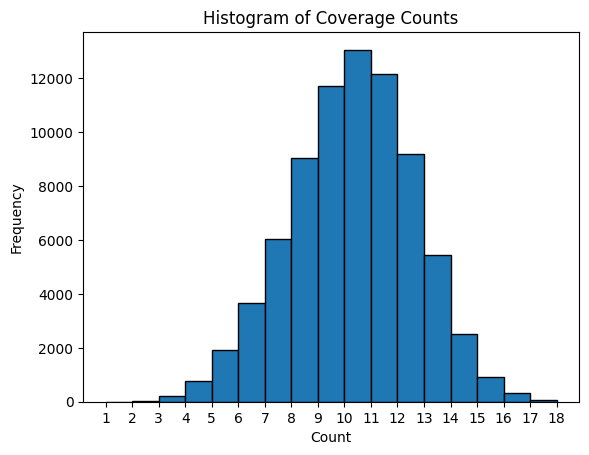

In [ ]:
import matplotlib.pyplot as plt

# Extracting counts from each recipe
counts = [sum(recipe.coverage_dict.values()) for recipe in filtered_recipes]

# Finding the range of count values
min_count = min(counts)
max_count = max(counts)

# Plotting the histogram with one bin for each integer value
plt.hist(counts, bins=range(min_count, max_count + 1), edgecolor='black')
plt.xticks(range(min_count, max_count + 1))  # Set x-ticks to show each integer
plt.title('Histogram of Coverage Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()


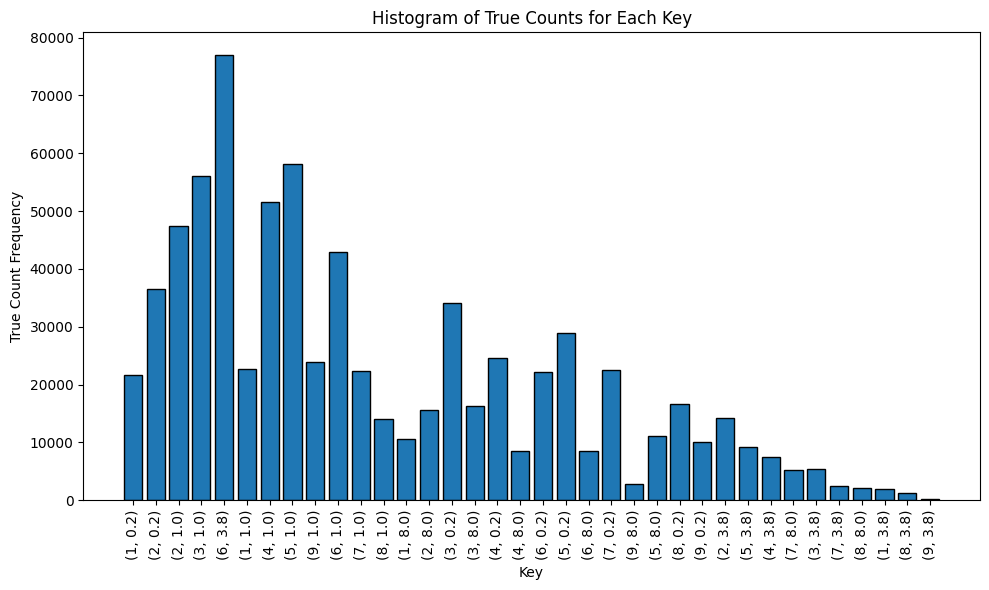

In [ ]:
import matplotlib.pyplot as plt

# Initialize a dictionary to hold counts of True values for each key
true_counts = {}

# Count True occurrences for each key
for recipe in filtered_recipes:
    for key, value in recipe.coverage_dict.items():
        if value:  # Check if the value is True
            true_counts[key] = true_counts.get(key, 0) + 1

# Converting tuple keys to string representations for better plotting
keys = [str(key) for key in true_counts.keys()]
counts = list(true_counts.values())

# Checking the lengths of keys and counts
if len(keys) != len(counts):
    raise ValueError(f"Length mismatch: keys length is {len(keys)}, counts length is {len(counts)}")

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
plt.bar(keys, counts, edgecolor='black')
plt.title('Histogram of True Counts for Each Key')
plt.xlabel('Key')
plt.ylabel('True Count Frequency')
plt.xticks(rotation=90)  # Rotate x-ticks if there are many keys
plt.tight_layout()  # Adjust layout for better fit
plt.show()





Next code refers to a failed attempt at a genetic algorithm

In [ ]:
''' 
import random
from itertools import product

# Assume `filtered_recipes` is your list of Recipe objects
# Assume `all_ranks` and `all_ratio_skill` are defined and used to create `total_dict`

population_size = 100  # Number of individuals in each generation
max_generations = 1000   # Maximum number of generations
mutation_rate = 0.0001   # Probability of mutation
greedy_solution_best_amount = len(list_of_best_recipes)
PENALTY_FACTOR = 1000  # Penalty factor for each recipe used above the greedy solution

# Calculate the coverage for each recipe
recipe_coverages = [sum(recipe.coverage_dict.values()) for recipe in filtered_recipes]

# Normalize these values to use in mutation probabilities
max_coverage = max(recipe_coverages)
normalized_coverages = [coverage / max_coverage for coverage in recipe_coverages]

# Find the maximum true count to normalize
max_true_count = max(true_counts.values())

# Normalize true counts (inverse because we want rarer keys to have more weight)
normalized_true_counts = {key: (max_true_count / count) for key, count in true_counts.items()}


def greedy_solution_to_ga_format(list_of_best_recipes, filtered_recipes):
    return [recipe in list_of_best_recipes for recipe in filtered_recipes]



def create_individual():
    return [random.choice([True, False]) for _ in filtered_recipes]


def create_skewed_individual():
    individual = [False] * len(filtered_recipes)
    desired_amount = random.randint(1, greedy_solution_best_amount)
    
    # Choose recipes based on their coverage weights
    weighted_recipes = random.choices(range(len(filtered_recipes)), weights=normalized_coverages, k=desired_amount)
    
    for i in weighted_recipes:
        individual[i] = True
    return individual


def create_population_with_greedy(population_size, list_of_best_recipes, filtered_recipes):
    population = [create_skewed_individual() for _ in range(population_size - 1)]
    greedy_individual = greedy_solution_to_ga_format(list_of_best_recipes, filtered_recipes)
    population.append(greedy_individual)  # Add the greedy solution to the population
    return population

# Create initial population
population = create_population_with_greedy(population_size, list_of_best_recipes, filtered_recipes)

def create_initial_population(population_size, true_counts, filtered_recipes):
    population = []
    average_count = sum(true_counts.values()) / len(true_counts)
    
    for _ in range(population_size):
        individual = [False] * len(filtered_recipes)
        
        # Sort the recipes by their rarity based on the coverage dictionary
        recipes_sorted_by_rarity = sorted(filtered_recipes, key=lambda r: sum(r.coverage_dict.values()))
        
        # Ensure that rare keys have a higher chance of being covered
        for i, recipe in enumerate(recipes_sorted_by_rarity):
            coverage_true_count = sum(recipe.coverage_dict.values())
            if coverage_true_count < average_count:
                # Random chance to include the recipe based on rarity
                if random.random() < (average_count / coverage_true_count):
                    individual[i] = True
        
        population.append(individual)
    
    return population


population = create_initial_population(population_size, true_counts, filtered_recipes)

def calculate_fitness(individual):
    coverage_dict = {(rank, ratio): False for rank, ratio in product(all_ranks, all_ratio_skill)}
    num_recipes_used = sum(individual)
    
    for recipe, included in zip(filtered_recipes, individual):
        if included:
            for key in coverage_dict:
                coverage_dict[key] = coverage_dict[key] or recipe.coverage_dict.get(key, False)

    true_count = sum(coverage_dict.values())
    
    # Apply penalty only if the amount of recipes used is higher than greedy_solution_best_amount
    recipe_penalty = max(0, num_recipes_used - greedy_solution_best_amount) * 1000

    return true_count - recipe_penalty

def calculate_fitness(individual, normalized_true_counts):
    fitness = 0
    
    for recipe, included in zip(filtered_recipes, individual):
        if included:
            for key in recipe.coverage_dict:
                if recipe.coverage_dict[key]:
                    # The weight is inversely proportional to the frequency count
                    fitness += normalized_true_counts[key]
    
    # Penalize the number of recipes used
    fitness -= sum(individual) * PENALTY_FACTOR  # Define PENALTY_FACTOR appropriately

    return fitness





def tournament_selection(population, tournament_size, fitness_args):
    selected = random.sample(population, tournament_size)
    # Pass additional arguments to calculate_fitness
    selected.sort(key=lambda ind: calculate_fitness(ind, *fitness_args), reverse=True)
    return selected[0]


def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    return parent1[:crossover_point] + parent2[crossover_point:], parent2[:crossover_point] + parent1[crossover_point:]

# Define the heuristic_crossover function using the normalized coverages
def heuristic_crossover(parent1, parent2, normalized_coverages):
    # Initialize offspring with None to indicate undecided genes
    offspring = [None] * len(parent1)

    # Loop over each gene position
    for i in range(len(parent1)):
        # If both parents have the same gene, inherit it
        if parent1[i] == parent2[i]:
            offspring[i] = parent1[i]
        else:
            # Use normalized coverages to weigh the probability of inheriting the gene
            # The higher the coverage, the more likely to inherit the gene from the parent where it's True
            if random.random() < normalized_coverages[i]:
                offspring[i] = parent1[i] if parent1[i] else parent2[i]
            else:
                offspring[i] = parent2[i] if parent2[i] else parent1[i]

    # Resolve any undecided genes (if they exist)
    for i in range(len(offspring)):
        if offspring[i] is None:
            offspring[i] = random.choice([parent1[i], parent2[i]])

    return offspring


def mutate(individual):
    mutated_individual = []
    for gene, coverage in zip(individual, normalized_coverages):
        if gene:
            # Lower chance to flip if the recipe has higher coverage
            mutation_chance = mutation_rate * (1 - coverage)
        else:
            # Higher chance to flip if the recipe has higher coverage
            mutation_chance = mutation_rate * coverage

        mutated_gene = not gene if random.random() < mutation_chance else gene
        mutated_individual.append(mutated_gene)

    return mutated_individual

def mutate(individual, true_counts, filtered_recipes):
    # Determine average count to set a threshold for rarity
    average_count = sum(true_counts.values()) / len(true_counts)

    for i, included in enumerate(individual):
        recipe = filtered_recipes[i]
        recipe_true_count = sum(recipe.coverage_dict.values())

        if included and recipe_true_count > average_count:
            # Flip the gene with higher frequency more readily
            if random.random() < mutation_rate:
                individual[i] = not individual[i]
        elif not included and recipe_true_count < average_count:
            # Flip the gene with lower frequency less readily
            if random.random() < mutation_rate / 2:
                individual[i] = not individual[i]
    return individual



'''

''' 
for generation in range(max_generations):
    new_population = []
    for _ in range(population_size // 2):
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)
        offspring1 = heuristic_crossover(parent1, parent2,normalized_coverages)
        offspring2 = heuristic_crossover(parent1, parent2,normalized_coverages)
        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)
        new_population.extend([offspring1, offspring2])
    population = new_population

    # Optional: Print the best fitness in this generation
    best_fitness = max(calculate_fitness(individual) for individual in population)
    print(f"Generation {generation}: Best Fitness = {best_fitness}")
'''

'''
# Assuming the rest of your GA setup is already in place

#population = create_initial_population(population_size, true_counts)

# Assuming calculate_fitness requires normalized_true_counts, which is a list or dict
fitness_args = (normalized_true_counts,)

for generation in range(max_generations):
    new_population = []
    
    for _ in range(population_size // 2):
        parent1 = tournament_selection(population, 10, fitness_args)
        parent2 = tournament_selection(population, 10, fitness_args)
        
        offspring1 = heuristic_crossover(parent1, parent2, true_counts)
        offspring2 = heuristic_crossover(parent1, parent2, true_counts)
        
        offspring1 = mutate(offspring1, true_counts, filtered_recipes)
        offspring2 = mutate(offspring2, true_counts, filtered_recipes)
        
        new_population.extend([offspring1, offspring2])
    
    population = new_population

    # Evaluate fitness
    best_fitness = max(calculate_fitness(individual, normalized_true_counts) for individual in population)
    print(f"Generation {generation}: Best Fitness = {best_fitness}")



best_individual = max(population, key=calculate_fitness)
best_recipe_indices = [i for i, included in enumerate(best_individual) if included]
best_recipes = [filtered_recipes[i] for i in best_recipe_indices]

print("Best Recipes:", best_recipes)
'''

'\n# Assuming the rest of your GA setup is already in place\n\n#population = create_initial_population(population_size, true_counts)\n\n# Assuming calculate_fitness requires normalized_true_counts, which is a list or dict\nfitness_args = (normalized_true_counts,)\n\nfor generation in range(max_generations):\n    new_population = []\n    \n    for _ in range(population_size // 2):\n        parent1 = tournament_selection(population, 10, fitness_args)\n        parent2 = tournament_selection(population, 10, fitness_args)\n        \n        offspring1 = heuristic_crossover(parent1, parent2, true_counts)\n        offspring2 = heuristic_crossover(parent1, parent2, true_counts)\n        \n        offspring1 = mutate(offspring1, true_counts, filtered_recipes)\n        offspring2 = mutate(offspring2, true_counts, filtered_recipes)\n        \n        new_population.extend([offspring1, offspring2])\n    \n    population = new_population\n\n    # Evaluate fitness\n    best_fitness = max(calculate_f